In [16]:
# -*- coding: utf-8 -*-
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from numpy.linalg import norm
%matplotlib inline

def rgbImg(img):
    if not isinstance(img, np.ndarray):
        raise TypeError('Input image type is not numpy.ndarray.')
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def grayImg(img):
    if not isinstance(img, np.ndarray):
        raise TypeError('Input image type is not numpy.ndarray.')
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def getImg(path):
    img = cv2.imread(path)
    if img is None:
        raise RuntimeError('Can not read img from the path.')
    return img

def normalize(img):
    img_back = img.copy()
    cv2.normalize(img, img_back, 0, 255, cv2.NORM_MINMAX)
    return img_back

# 辨識&切下text區塊圖片傳回
def find_text_area(img):
    texts = []
    gray = grayImg(img)
    bl = cv2.medianBlur(gray, 3)
    ret, th = cv2.threshold(bl,20,255, cv2.THRESH_BINARY_INV)
    kernel = cv2.getStructuringElement(cv2.MORPH_ERODE,(3, 3))
    er1 = cv2.erode(th, kernel, 1)
    zero_cnts = cv2.findNonZero(er1)
    window = np.zeros(th.shape, dtype = np.uint8)
    cv2.drawContours(window, [zero_cnts], 0, (255,255,255), 1)
    er_kernel = cv2.getStructuringElement(cv2.MORPH_ERODE,(5, 7))
    er2 = cv2.erode(window, er_kernel, 1)
    di_kernel = cv2.getStructuringElement(cv2.MORPH_DILATE,(5, 7))
    di1 = cv2.dilate(er2, di_kernel, 1)
    cnts2, hierarchy= cv2.findContours(di1, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    for i, c in enumerate(cnts2):
        min_rect = cv2.minAreaRect(c)
        box = np.int0(cv2.cv.BoxPoints(min_rect))
        rec_sum = box.sum(axis=1)
        point1 = box[np.argmin(rec_sum)]
        point2 = box[np.argmax(rec_sum)]        
        text_img = img[point1[1]+1:point2[1], point1[0]:point2[0]]
        texts.append(text_img)
    return texts[::-1]

#由text圖片切割字元, 傳回字元list
def seg(text):
    seg_list = []
    um = text[:,143:,:]
    num_right = text[:,106:143,:]
    dot = text[:,100:106,:]
    num_left = text[:,:100,:]
    
    seg_list.append(um)

    right_length = 143-106
    for i in xrange(0, (143-106)/12):
        seg_img = num_right[:,right_length-12:right_length,:]
        seg_list.append(seg_img)
        right_length = right_length - 12    
    seg_list.append(dot)

    left_length = 100
    for i in xrange(0, 100/12):
        seg_img = num_left[:,left_length-12:left_length,:]
        seg_list.append(seg_img)
        left_length = left_length - 12
    return seg_list

#以線性內插法修改圖片size
def resize(img, size):
    if not isinstance(img, np.ndarray):
        raise TypeError('Input image type is not numpy.ndarray.')
    elif not isinstance(size, tuple):
        raise TypeError('Input size type is not tuple.')
    elif len(size) > 2 or len(size)< 2:
        raise ValueError('Input size is invalid.')
    return cv2.resize(img, size, interpolation=cv2.INTER_LINEAR)

#利用sobel邊緣產生hist當成圖片特徵向量
def convert2vector(seg_list):
    data_list = []
    
    for seg_img in seg_list:
        res_img = resize(seg_img,(20,20))
        gray = grayImg(res_img)

        gx = cv2.Sobel(gray, cv2.CV_32F, 1, 0)
        gy = cv2.Sobel(gray, cv2.CV_32F, 0, 1)
        mag, ang = cv2.cartToPolar(gx, gy)
        bin_n = 16
        bin = np.int32(bin_n*ang/(2*np.pi))
        bin_cells = bin[:10,:10], bin[10:,:10], bin[:10,10:], bin[10:,10:]
        mag_cells = mag[:10,:10], mag[10:,:10], mag[:10,10:], mag[10:,10:]
        hists = [np.bincount(b.ravel(), m.ravel(), bin_n) for b, m in zip(bin_cells, mag_cells)]
        hist = np.hstack(hists)

        eps = 1e-7
        hist /= hist.sum() + eps
        hist = np.sqrt(hist)
        hist /= norm(hist) + eps

        data_list.append(hist)
    dataMat = np.array(data_list, np.float32)
    return dataMat

def prediction(testDataMat):
    #dic = {'11':'blank', '12':'dot', '13':'minus', '14':'um'}
    #dic = {'11':'', '12':'.', '13':'-', '14':''}
    result = None
    output = ''
    svm = cv2.SVM()
    svm.load('D:/AOI/OCR_model/OCR_model')
    response = svm.predict_all(testDataMat)
    for i, res in enumerate(response[::-1]):
        #if dic.has_key(str(int(res[0]))):
        #    result = dic[str(int(res[0]))]
        #else:
        #    result = str(int(res))
        result = str(int(res))
        output = output + result
    return float(output)

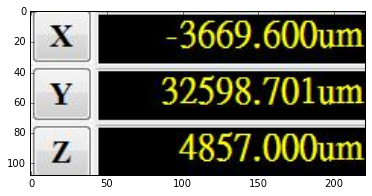

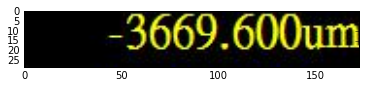

Answer: -3669.6


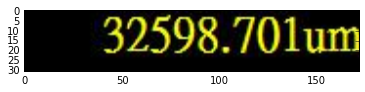

Answer: 32598.701


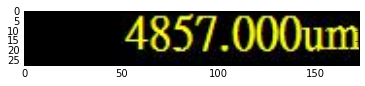

Answer: 4857.0


In [152]:
img = getImg('D:/AOI/OCR_segments/step2/test_data_03/0016-S2-維修-凹陷-座標.jpg'.decode('utf8').encode('big5'))
plt.imshow(rgbImg(img))
plt.show()
    
texts = find_text_area(img)

for text in texts:
    plt.imshow(rgbImg(text))
    plt.show()
    
    seg_list = seg(text)
    test_data = convert2vector(seg_list)
    result = prediction(test_data)
    print 'Answer:', result

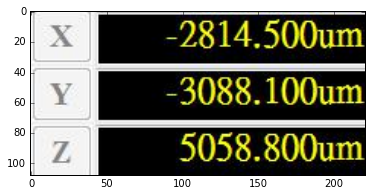

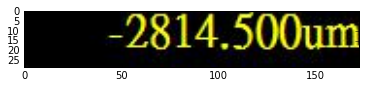

Answer: -2814.5


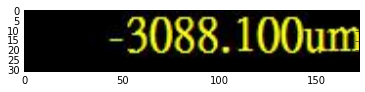

Answer: -3088.1


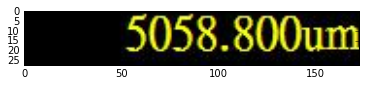

Answer: 5058.8


In [153]:
img = getImg('D:/AOI/OCR_segments/step2/test_data_03/0022-S3-維修-凹陷-座標.jpg'.decode('utf8').encode('big5'))
plt.imshow(rgbImg(img))
plt.show()
    
texts = find_text_area(img)

for text in texts:
    plt.imshow(rgbImg(text))
    plt.show()
    
    seg_list = seg(text)
    test_data = convert2vector(seg_list)
    result = prediction(test_data)
    print 'Answer:', result

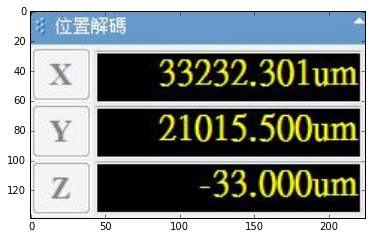

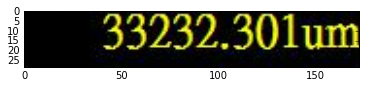

Answer: 33232.301


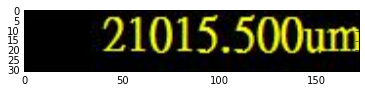

Answer: 21015.5


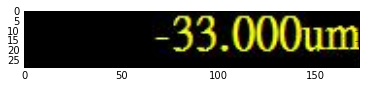

Answer: -33.0


In [154]:
img = getImg('D:/AOI/OCR_segments/step2/test_data_03/0333-S1-維修-殘膠-座標.jpg'.decode('utf8').encode('big5'))
plt.imshow(rgbImg(img))
plt.show()
    
texts = find_text_area(img)

for text in texts:
    plt.imshow(rgbImg(text))
    plt.show()
    
    seg_list = seg(text)
    test_data = convert2vector(seg_list)
    result = prediction(test_data)
    print 'Answer:', result

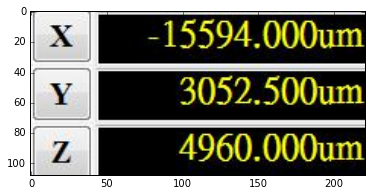

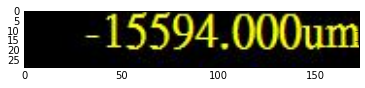

Answer: -15594.0


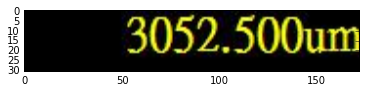

Answer: 3052.5


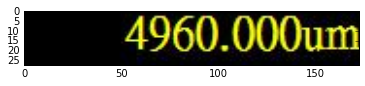

Answer: 4960.0


In [155]:
img = getImg('D:/AOI/OCR_segments/step2/test_data_03/S5-右上-座標.jpg'.decode('utf8').encode('big5'))
plt.imshow(rgbImg(img))
plt.show()
    
texts = find_text_area(img)

for text in texts:
    plt.imshow(rgbImg(text))
    plt.show()
    
    seg_list = seg(text)
    test_data = convert2vector(seg_list)
    result = prediction(test_data)
    print 'Answer:', result

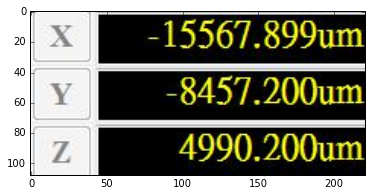

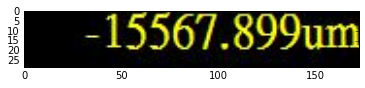

Answer: -15567.899


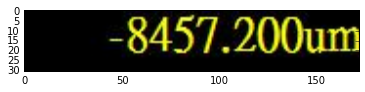

Answer: -8457.2


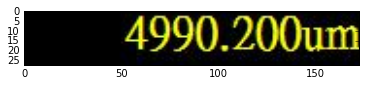

Answer: 4990.2


In [156]:
img = getImg('D:/AOI/OCR_segments/step2/test_data_03/S5-右下-座標.jpg'.decode('utf8').encode('big5'))
plt.imshow(rgbImg(img))
plt.show()
    
texts = find_text_area(img)

for text in texts:
    plt.imshow(rgbImg(text))
    plt.show()
    
    seg_list = seg(text)
    test_data = convert2vector(seg_list)
    result = prediction(test_data)
    print 'Answer:', result

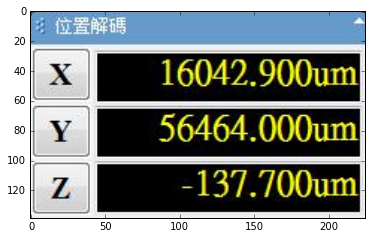

Gray-scale input:


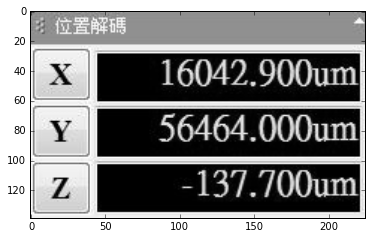

Median blur:


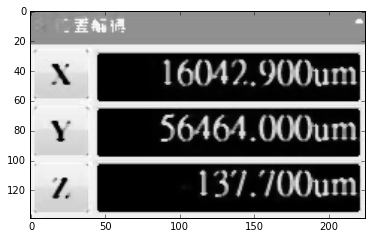

Treshhold of binary inv:


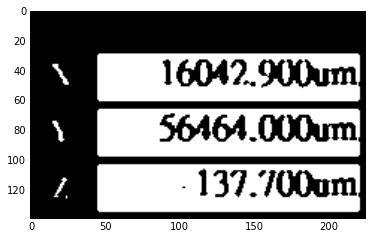

Erode with 3*3 kernel


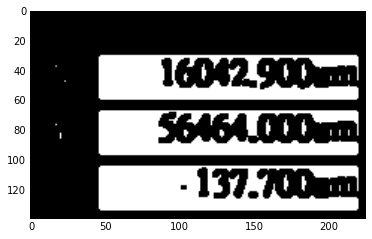

Find contours of non-zero area :


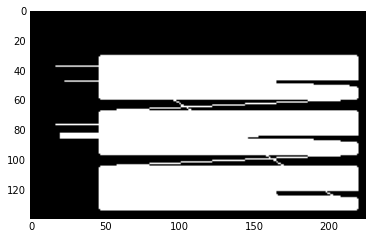

Erode with 5*7 kernel:


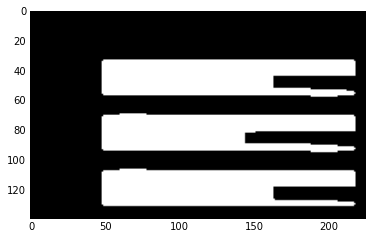

Dilate with 5*7 kernel:


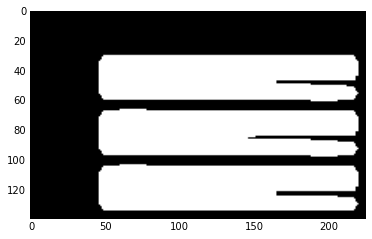

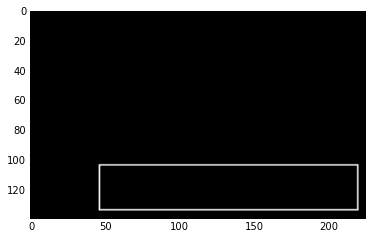

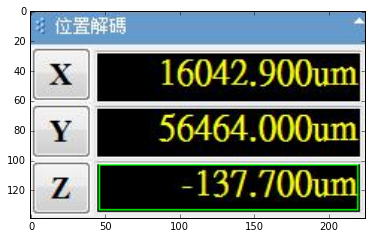

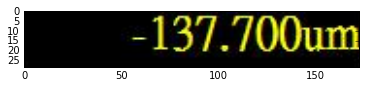

(29L, 173L, 3L)


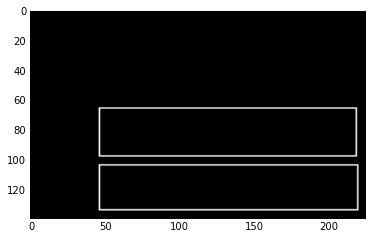

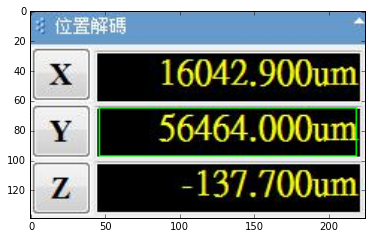

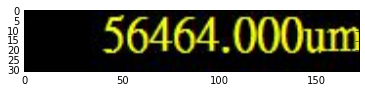

(31L, 172L, 3L)


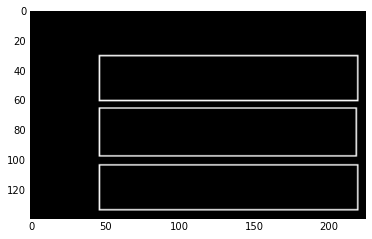

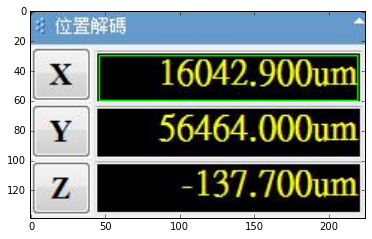

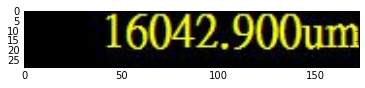

(29L, 173L, 3L)
Find the texts:


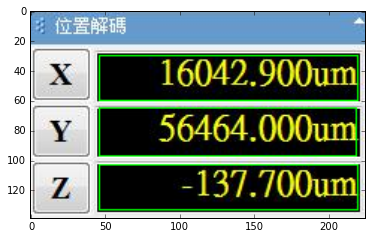

In [57]:
#辨識text區塊處理流程實驗區

# -*- coding: utf-8 -*-
img = getImg('D:/AOI/OCR_data/0201-S2-維修-殘膠-座標.jpg'.decode('utf8').encode('big5'))
plt.imshow(rgbImg(img))
plt.show()

gray = grayImg(img)
print 'Gray-scale input:'
plt.imshow(gray,'gray')
plt.show()

gcopy = gray.copy()
bl = cv2.medianBlur(gcopy, 3)
print 'Median blur:'
plt.imshow(bl,'gray')
plt.show()

ret, th = cv2.threshold(bl,20,255, cv2.THRESH_BINARY_INV)
print 'Treshhold of binary inv:'
plt.imshow(th,'gray')
plt.show()

kernel = cv2.getStructuringElement(cv2.MORPH_ERODE,(3, 3))
er1 = cv2.erode(th, kernel, 1)
print 'Erode with 3*3 kernel'
plt.imshow(er1, 'gray')
plt.show()

zero_cnts = cv2.findNonZero(er1)
window = np.zeros(th.shape, dtype = np.uint8)
cv2.drawContours(window, [zero_cnts], 0, (255,255,255), 1)
print 'Find contours of non-zero area :'
plt.imshow(window, 'gray')
plt.show()

er_kernel = cv2.getStructuringElement(cv2.MORPH_ERODE,(5, 7))
er2 = cv2.erode(window, er_kernel, 1)
print 'Erode with 5*7 kernel:'
plt.imshow(er2, 'gray')
plt.show()

di_kernel = cv2.getStructuringElement(cv2.MORPH_DILATE,(5, 7))
di1 = cv2.dilate(er2, di_kernel, 1)
print 'Dilate with 5*7 kernel:'
plt.imshow(di1, 'gray')
plt.show()

copy = img.copy()
texts = []
window = np.zeros(gray.shape, dtype=np.uint8)
cnts2, hierarchy= cv2.findContours(di1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for i, c in enumerate(cnts2):
    img_copy = img.copy()
    min_rect = cv2.minAreaRect(c)
    
    box = np.int0(cv2.cv.BoxPoints(min_rect))
    rec_sum = box.sum(axis=1)
    point1 = box[np.argmin(rec_sum)]
    point2 = box[np.argmax(rec_sum)]
    
    cv2.rectangle(window, tuple(point1), tuple(point2), (255,255,255), 1)
    plt.imshow(window,'gray')
    plt.show()
    
    cv2.rectangle(img_copy, tuple(point1), tuple(point2), (0,255,0), 1)
    cv2.rectangle(copy, tuple(point1), tuple(point2), (0,255,0), 1)
    plt.imshow(rgbImg(img_copy))
    plt.show()
    
    text_img = img[point1[1]+1:point2[1], point1[0]:point2[0]]
    plt.imshow(rgbImg(text_img))
    plt.show()
    print text_img.shape
    
print 'Find the texts:'
plt.imshow(rgbImg(copy))
plt.show()


#for i, c in enumerate(cnts2):
#        min_rect = cv2.minAreaRect(c)
#        box = np.int0(cv2.cv.BoxPoints(min_rect))
#        rec_sum = box.sum(axis=1)
#        point1 = box[np.argmin(rec_sum)]
#        point2 = box[np.argmax(rec_sum)]        
#        text_img = img[point1[1]+1:point2[1], point1[0]:point2[0]]
#        texts.append(text_img)
#    return texts[::-1]

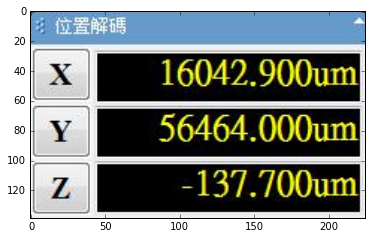

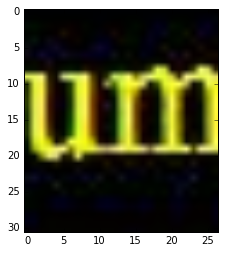

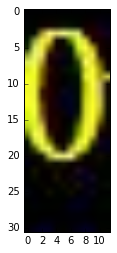

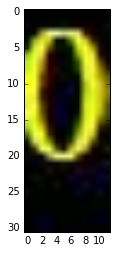

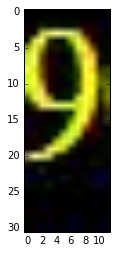

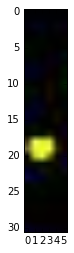

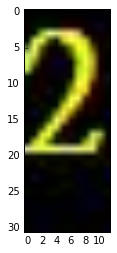

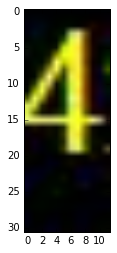

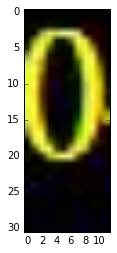

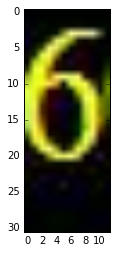

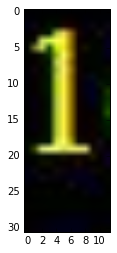

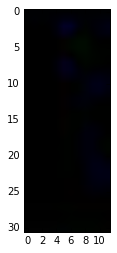

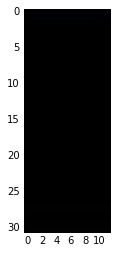

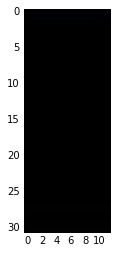

In [60]:
#切割數字實驗區

img = getImg('D:/AOI/OCR_data/0201-S2-維修-殘膠-座標.jpg'.decode('utf8').encode('big5'))
plt.imshow(rgbImg(img))
plt.show()

texts = find_text_area(img)
text = texts[0]

#um固定從143開始, 故0~143的數值區塊大小恒定
#數字寬度固定為12, 小數點寬度6
#小數點位置固定在100~106
#小數點左側區塊以100倒數, 每隔12像素切割一個區塊, 最左側不足寬度12的區塊捨去

um = text[:,143:,:]
num_right = text[:,106:143,:]
dot = text[:,100:106,:]
num_left = text[:,:100,:]

plt.imshow(rgbImg(um))
plt.show()

right_length = 143-106
for i in xrange(0, (143-106)/12):
    plt.imshow(rgbImg(num_right[:,right_length-12:right_length,:]))
    plt.show()
    right_length = right_length - 12    

plt.imshow(rgbImg(dot))
plt.show()    

left_length = 100
for i in xrange(0, 100/12):
    plt.imshow(rgbImg(num_left[:,left_length-12:left_length,:]))
    plt.show()
    left_length = left_length - 12
    

C:\Users\160619\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:21: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


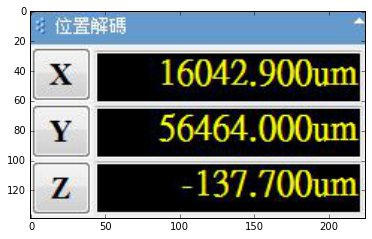

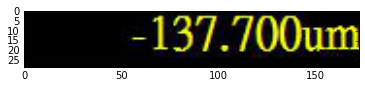

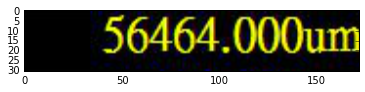

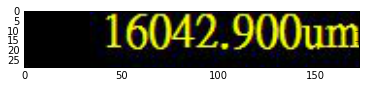

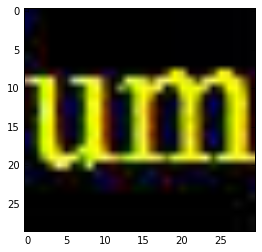

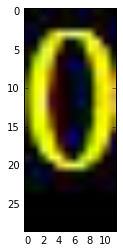

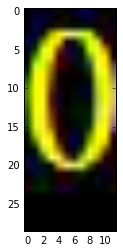

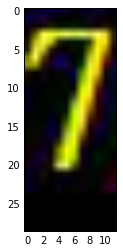

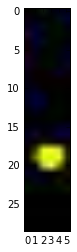

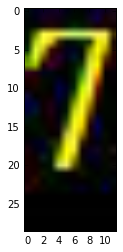

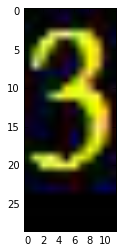

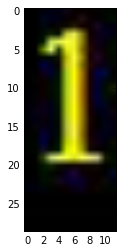

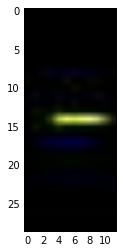

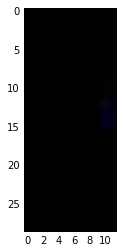

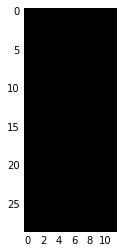

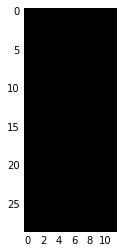

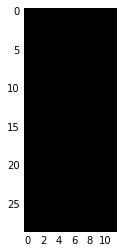

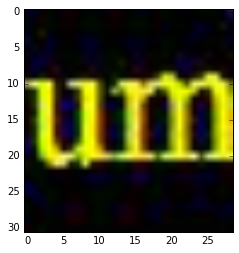

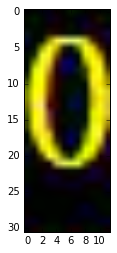

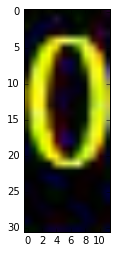

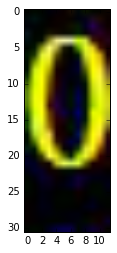

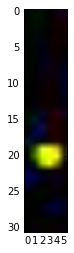

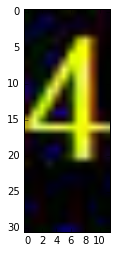

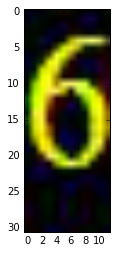

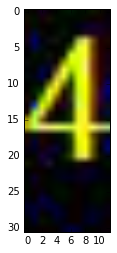

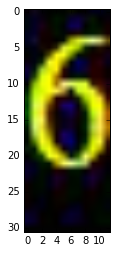

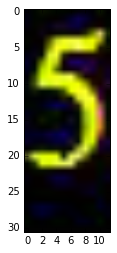

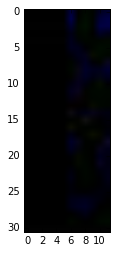

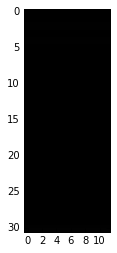

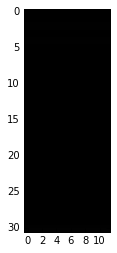

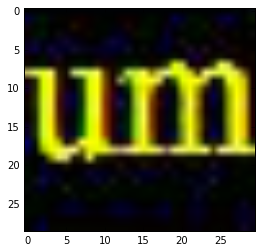

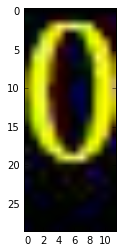

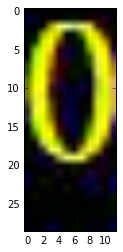

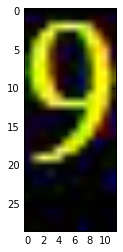

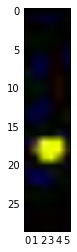

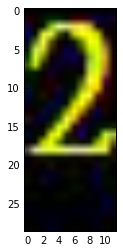

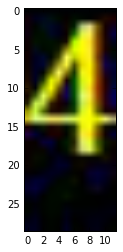

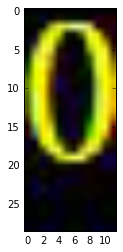

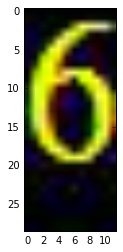

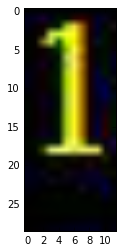

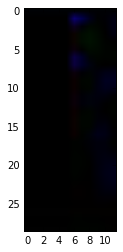

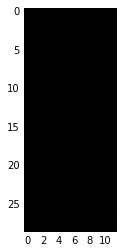

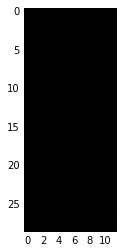

In [408]:
# XYZ深黑色, 5位數+3位小數
img = getImg('0201-S2-維修-殘膠-座標'.decode('utf8').encode('big5'))
plt.imshow(rgbImg(img))
plt.show()

texts = find_text_area(img)

for text in texts:
    plt.imshow(rgbImg(text))
    plt.show()
    
for text in texts:
    seg_num(text)

C:\Users\160619\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:21: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


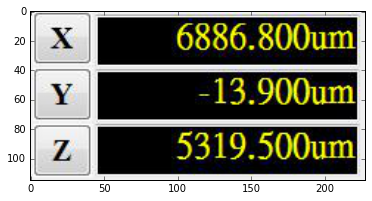

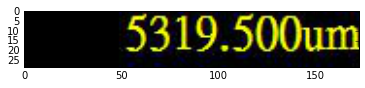

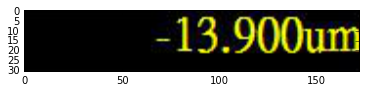

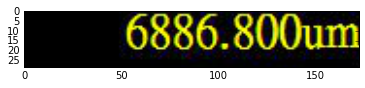

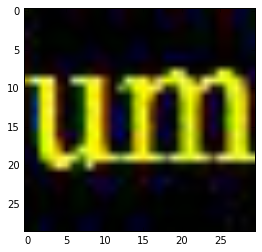

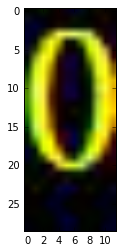

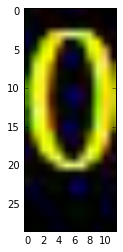

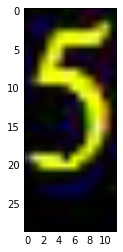

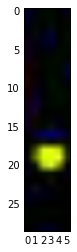

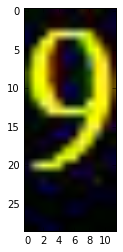

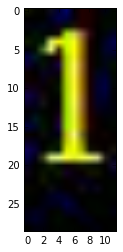

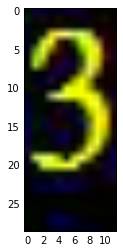

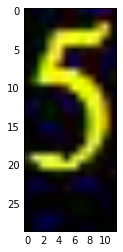

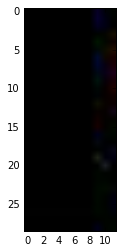

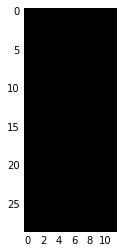

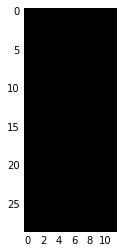

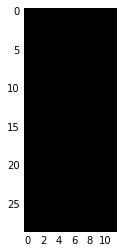

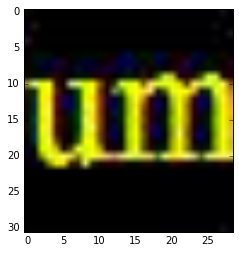

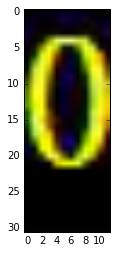

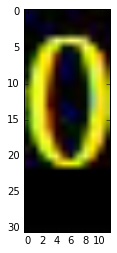

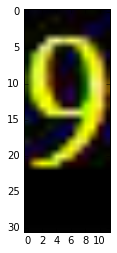

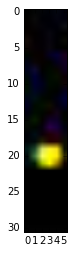

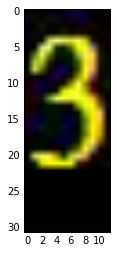

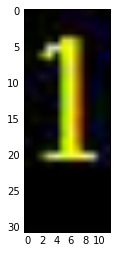

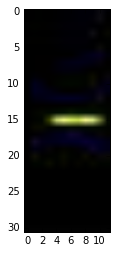

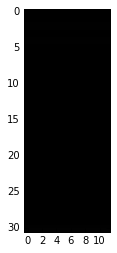

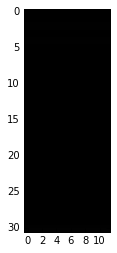

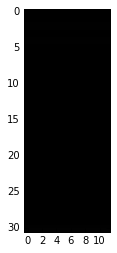

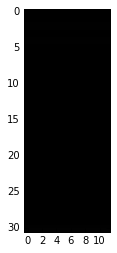

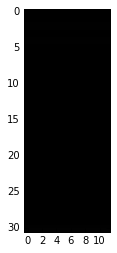

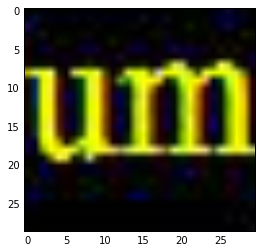

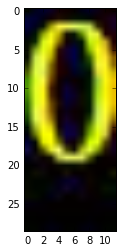

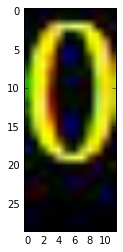

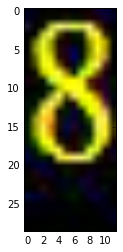

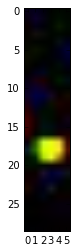

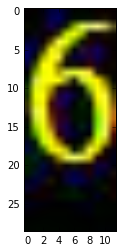

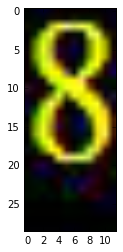

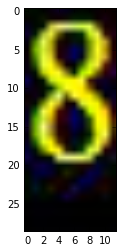

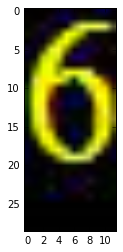

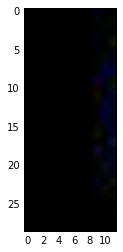

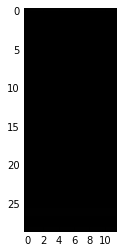

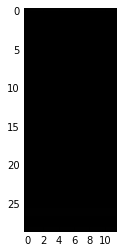

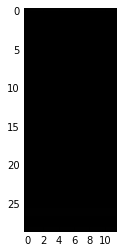

In [409]:
# 無title + XYZ深黑色
img = getImg('0070-S0-維修-殘膠-座標'.decode('utf8').encode('big5'))
plt.imshow(rgbImg(img))
plt.show()

texts = find_text_area(img)

for text in texts:
    plt.imshow(rgbImg(text))
    plt.show()
    
for text in texts:
    seg_num(text)

C:\Users\160619\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:21: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


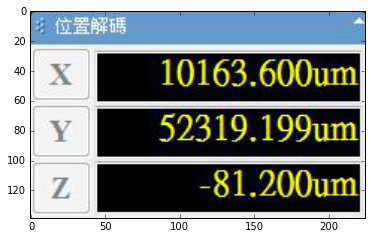

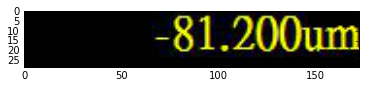

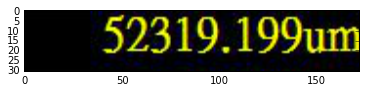

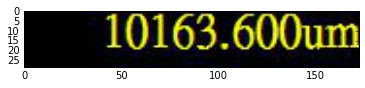

In [382]:
img = getImg('0045-S2-維修-殘膠-座標'.decode('utf8').encode('big5'))
plt.imshow(rgbImg(img))
plt.show()

texts = find_text_area(img)

for text in texts:
    plt.imshow(rgbImg(text))
    plt.show()

C:\Users\160619\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:21: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


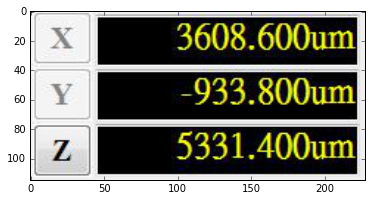

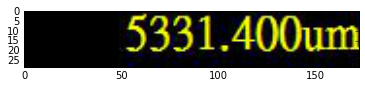

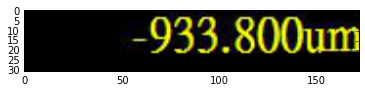

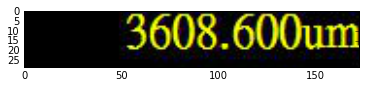

In [383]:
# 無title, Z深黑色, Z非負數
img = getImg('0064-S0-維修-殘膠-座標'.decode('utf8').encode('big5'))
plt.imshow(rgbImg(img))
plt.show()

texts = find_text_area(img)
for text in texts:
    plt.imshow(rgbImg(text))
    plt.show()

C:\Users\160619\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:21: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


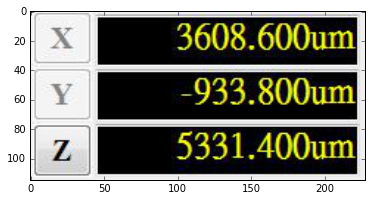

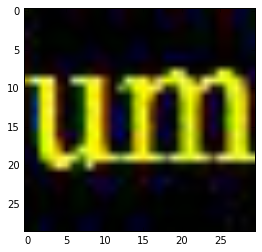

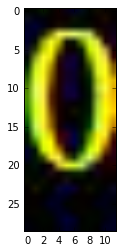

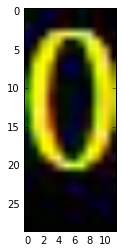

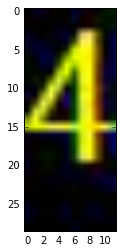

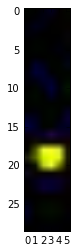

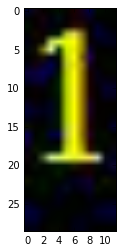

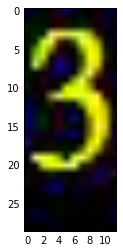

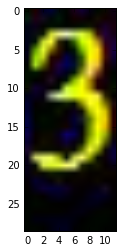

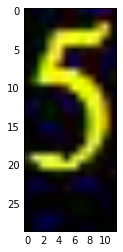

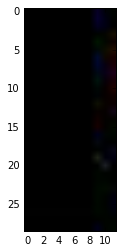

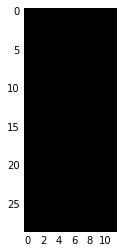

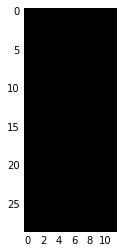

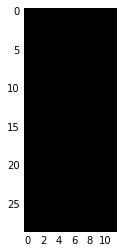

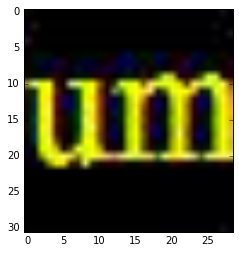

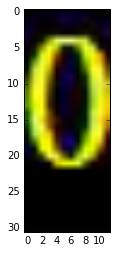

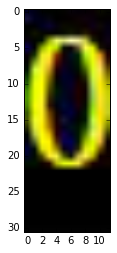

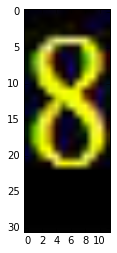

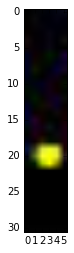

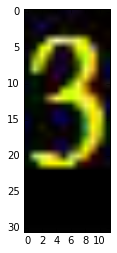

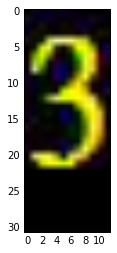

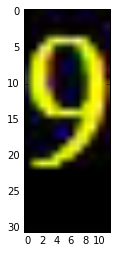

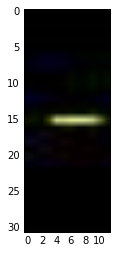

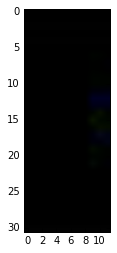

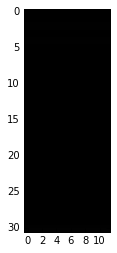

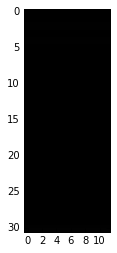

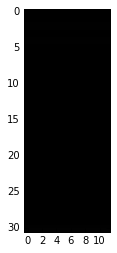

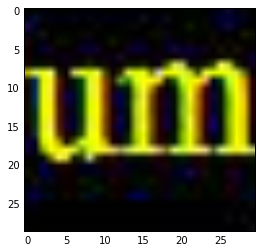

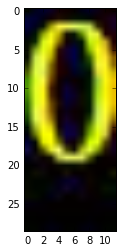

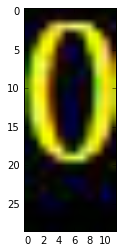

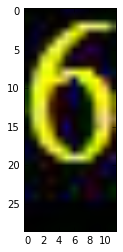

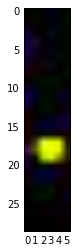

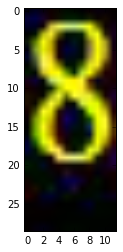

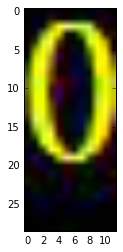

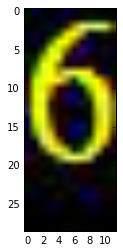

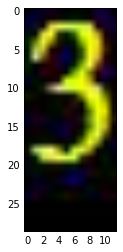

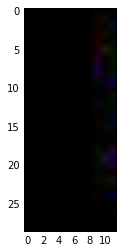

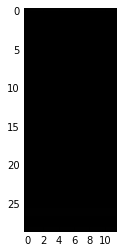

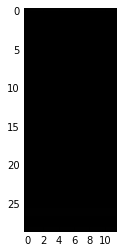

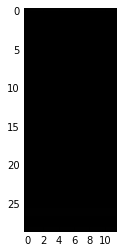

In [405]:

img = getImg('0064-S0-維修-殘膠-座標'.decode('utf8').encode('big5'))
plt.imshow(rgbImg(img))
plt.show()

texts = find_text_area(img)
for text in texts:
    seg_num(text)

C:\Users\160619\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:21: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


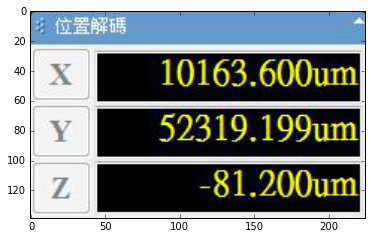

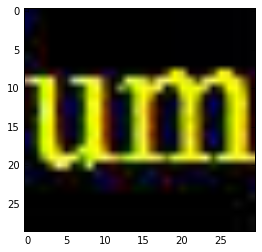

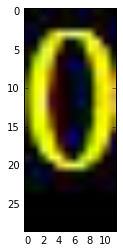

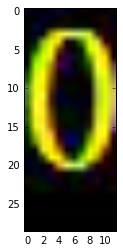

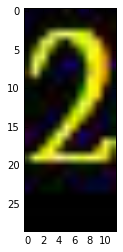

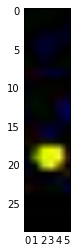

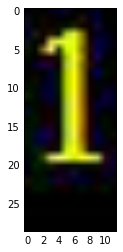

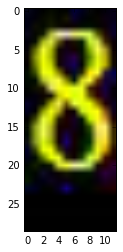

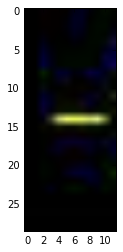

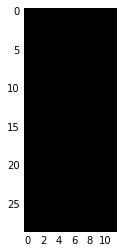

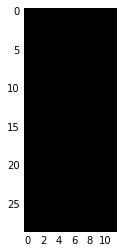

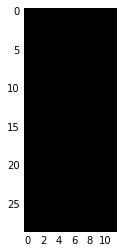

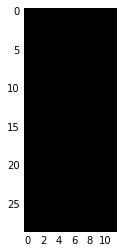

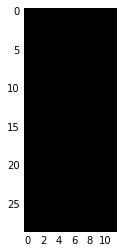

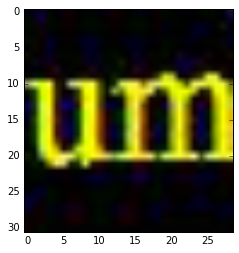

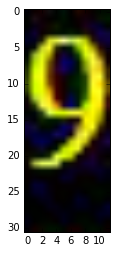

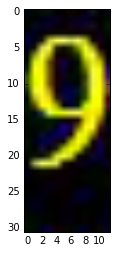

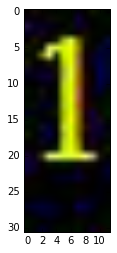

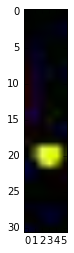

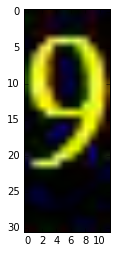

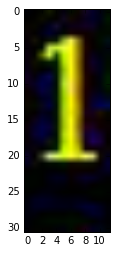

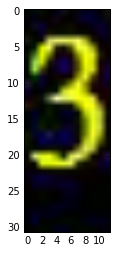

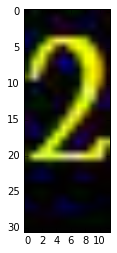

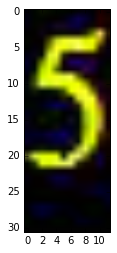

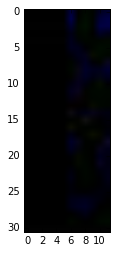

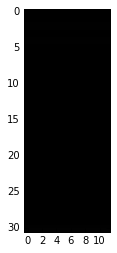

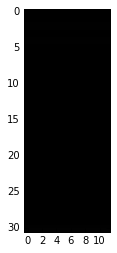

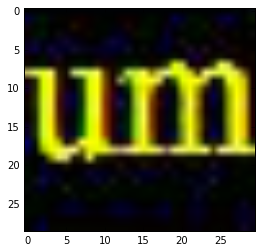

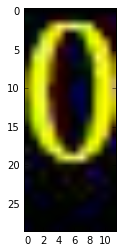

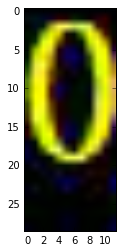

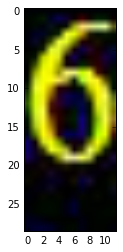

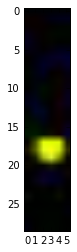

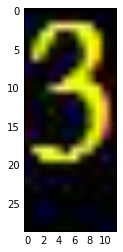

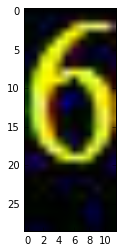

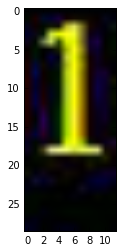

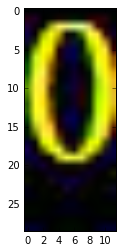

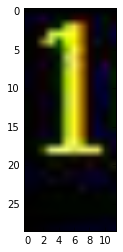

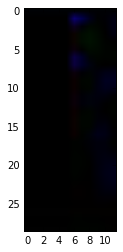

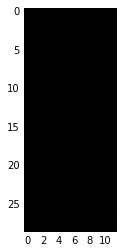

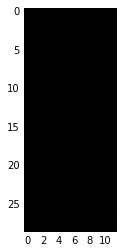

In [403]:
img = getImg('0045-S2-維修-殘膠-座標'.decode('utf8').encode('big5'))
plt.imshow(rgbImg(img))
plt.show()

texts = find_text_area(img)
for text in texts:
    seg_num(text)

C:\Users\160619\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:22: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


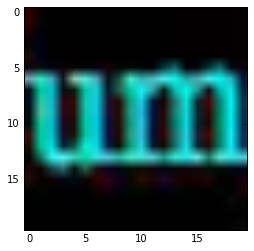

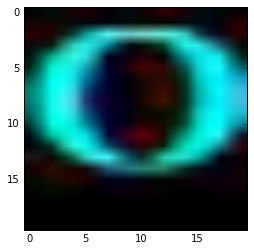

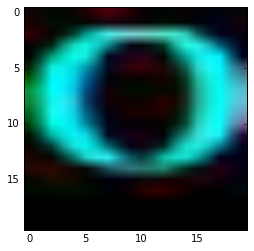

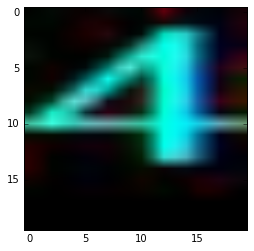

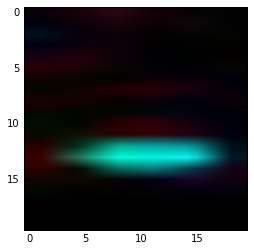

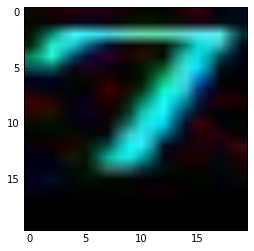

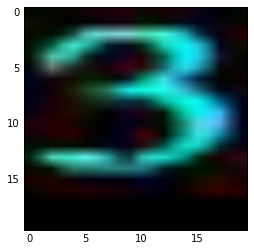

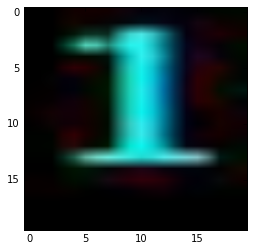

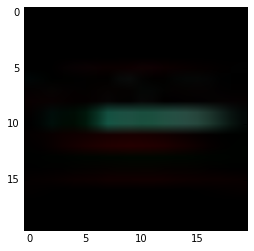

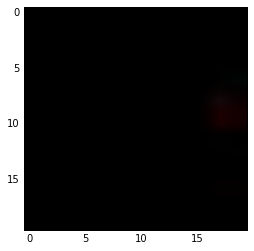

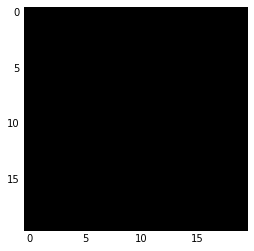

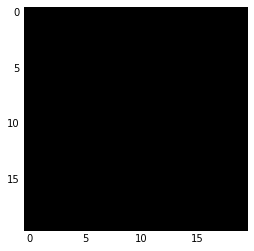

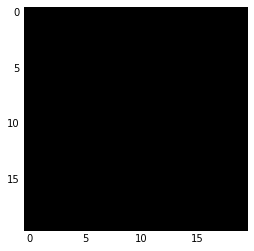

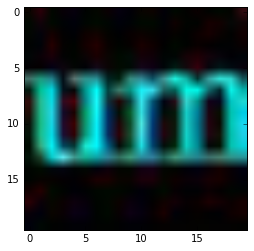

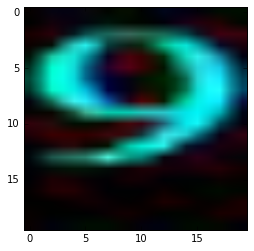

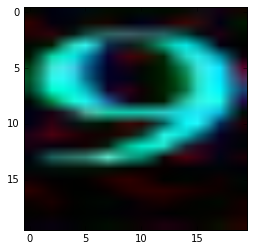

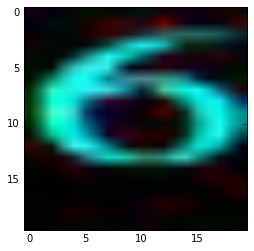

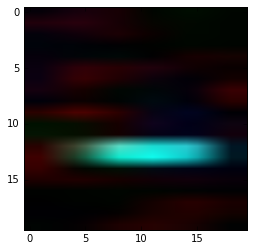

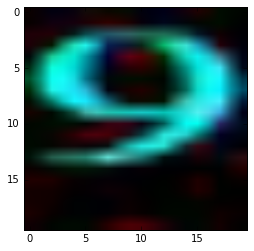

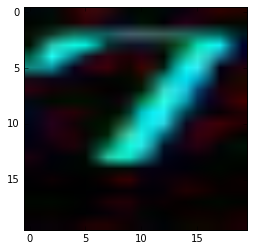

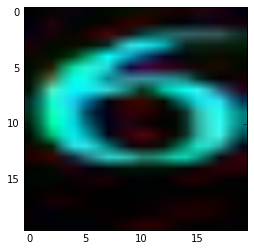

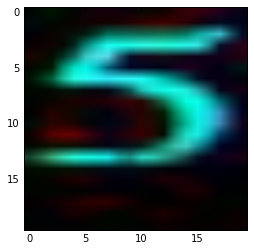

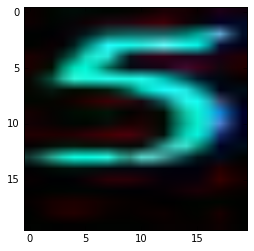

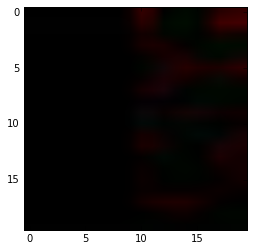

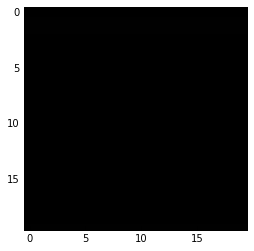

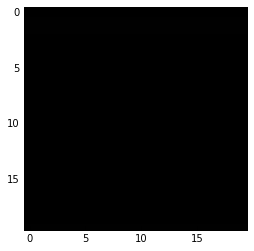

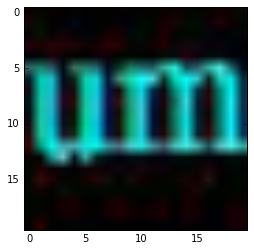

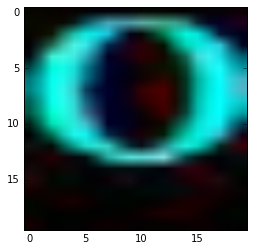

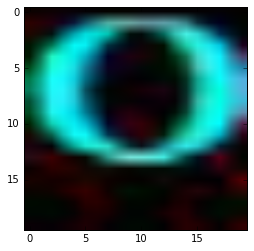

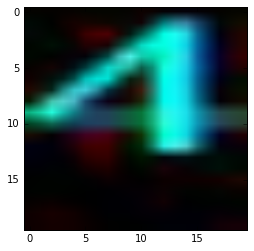

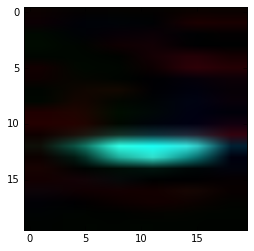

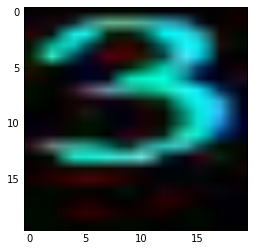

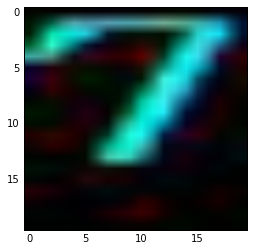

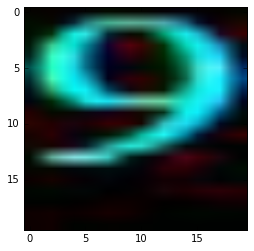

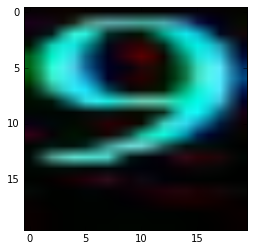

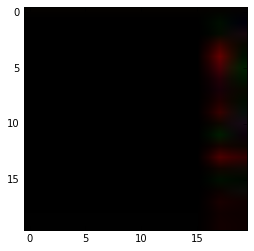

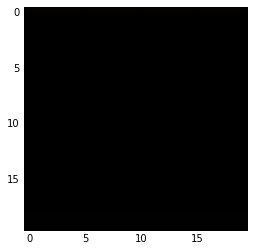

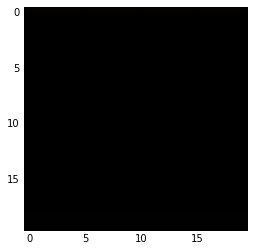

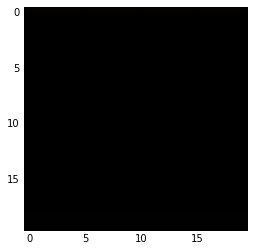

In [568]:
# 遍歷資料圖片做切片
import os
loading_path = 'D:/AOI/OCR_data/'
saving_path = 'D:/AOI/OCR_segments/step0/'

count = 0
seg_list = []
for dirPath, dirNames, fileNames in os.walk(loading_path):
    for fname in fileNames:
        if count == 1:
            break
        else:
            count = count + 1
            src_path = os.path.join(dirPath, fname)
            img = getImg(src_path)
            #plt.imshow(img)
            #plt.show()
            
            texts = find_text_area(img)
            for i, text in enumerate(texts):
                seg_list  = seg_num(text,(20,20))
                for index, seg in enumerate(seg_list):
                    #path = saving_path + '{}_{}_{}.jpg'.format(fname[:-4], i, index)
                    #print path
                    #cv2.imwrite(path, seg)
                    plt.imshow(seg)
                    plt.show()

In [17]:
#產生訓練集
from numpy.linalg import norm

#dic = {'11':'blank', '12':'dot', '13':'minus', '14':'um'}
prepare_list = ['0','1','2','3','4','5','6','7','8','9']
data_list = []
label_list = []

for label_name in prepare_list:
    path = 'D:/OCR_working_space/AOI/OCR_segments/step1/{}/'.format(label_name)
    #print path

    for dirPath, dirNames, fileNames in os.walk(path):
        for fname in fileNames:
            src_path = os.path.join(dirPath, fname)
            seg_img = getImg(src_path)
            #plt.imshow(rgbImg(seg_img))
            #plt.show()
            
            gr = grayImg(seg_img)
            #plt.imshow(gr,'gray')
            #plt.show()
            
            res_img = resize(seg_img,(20,20))

            gray = grayImg(res_img)
            #plt.imshow(gray,'gray')
            #plt.show()

            gx = cv2.Sobel(gray, cv2.CV_32F, 1, 0)
            gy = cv2.Sobel(gray, cv2.CV_32F, 0, 1)
            mag, ang = cv2.cartToPolar(gx, gy)
            
            absX = cv2.convertScaleAbs(gx)   # 转回uint8  
            absY = cv2.convertScaleAbs(gy)  
            dst = cv2.addWeighted(absX,0.5,absY,0.5,0)  
            #plt.imshow(dst,'gray')
            #plt.show()
            
            bin_n = 16
            bin = np.int32(bin_n*ang/(2*np.pi))
            bin_cells = bin[:10,:10], bin[10:,:10], bin[:10,10:], bin[10:,10:]
            mag_cells = mag[:10,:10], mag[10:,:10], mag[:10,10:], mag[10:,10:]
            hists = [np.bincount(b.ravel(), m.ravel(), bin_n) for b, m in zip(bin_cells, mag_cells)]
            hist = np.hstack(hists)
            #plt.imshow(hists,'gray')
            #plt.show()

            eps = 1e-7
            hist /= hist.sum() + eps
            hist = np.sqrt(hist)
            hist /= norm(hist) + eps

            data_list.append(hist)
            label_list.append(label_name)
            
trainingDataMat = np.array(data_list, np.float32)
labelsMat = np.array(label_list, np.int32)

In [20]:
#產生測試集
path = 'D:/OCR_working_space/AOI/OCR_segments/step2/test_data_02/'
count = 0
test_data = []
test_lebal = []
for dirPath, dirNames, fileNames in os.walk(path):
    for fname in fileNames:
        if count == -1:
            break
        else:
            src_path = os.path.join(dirPath, fname)
            test_lebal.append(fname.split('.')[1])
            print src_path.decode('big5')
            seg_img = getImg(src_path)
            res_img = resize(seg_img,(20,20))

            gray = grayImg(res_img)

            gx = cv2.Sobel(gray, cv2.CV_32F, 1, 0)
            gy = cv2.Sobel(gray, cv2.CV_32F, 0, 1)
            mag, ang = cv2.cartToPolar(gx, gy)
            bin_n = 16
            bin = np.int32(bin_n*ang/(2*np.pi))
            bin_cells = bin[:10,:10], bin[10:,:10], bin[:10,10:], bin[10:,10:]
            mag_cells = mag[:10,:10], mag[10:,:10], mag[:10,10:], mag[10:,10:]
            hists = [np.bincount(b.ravel(), m.ravel(), bin_n) for b, m in zip(bin_cells, mag_cells)]
            hist = np.hstack(hists)

            eps = 1e-7
            hist /= hist.sum() + eps
            hist = np.sqrt(hist)
            hist /= norm(hist) + eps
            test_data.append(hist)
            count += 1
testDataMat = np.array(test_data, np.float32)

D:/OCR_working_space/AOI/OCR_segments/step2/test_data_02/111332.9.jpg
D:/OCR_working_space/AOI/OCR_segments/step2/test_data_02/115396.14.jpg
D:/OCR_working_space/AOI/OCR_segments/step2/test_data_02/128351.1.jpg
D:/OCR_working_space/AOI/OCR_segments/step2/test_data_02/129560.9.jpg
D:/OCR_working_space/AOI/OCR_segments/step2/test_data_02/172332.11.jpg
D:/OCR_working_space/AOI/OCR_segments/step2/test_data_02/173346.14.jpg
D:/OCR_working_space/AOI/OCR_segments/step2/test_data_02/176599.12.jpg
D:/OCR_working_space/AOI/OCR_segments/step2/test_data_02/206002.0.jpg
D:/OCR_working_space/AOI/OCR_segments/step2/test_data_02/208608.9.jpg
D:/OCR_working_space/AOI/OCR_segments/step2/test_data_02/210036.3.jpg
D:/OCR_working_space/AOI/OCR_segments/step2/test_data_02/228507.11.jpg
D:/OCR_working_space/AOI/OCR_segments/step2/test_data_02/237226.12.jpg
D:/OCR_working_space/AOI/OCR_segments/step2/test_data_02/239745.0.jpg
D:/OCR_working_space/AOI/OCR_segments/step2/test_data_02/245131.11.jpg
D:/OCR_workin

In [23]:
params = {"kernel_type":cv2.SVM_LINEAR}

#訓練與預測
svm = cv2.SVM()
svm.train(trainingDataMat, labelsMat, params=params)
svm.save('D:/OCR_working_space/AOI/OCR_model/OCR_model2')
response = svm.predict_all(testDataMat)

In [71]:
response[0:10]

array([[  9.],
       [ 14.],
       [  1.],
       [  9.],
       [ 11.],
       [ 14.],
       [ 12.],
       [  0.],
       [  9.],
       [  3.]], dtype=float32)

In [22]:
# 列出結果與核對答案
#dic = {'11':'blank', '12':'dot', '13':'minus', '14':'um'}
print 'Result, Anser'
count = 0.0
err_count = 0.0
for i, res in enumerate(response):
    result = None
    anser = None
    if dic.has_key(str(int(res))):
        result  = dic[str(int(res))]
    else:
        result = int(res)
        
    #if dic.has_key(test_lebal[i]):
    #    anser  = dic[test_lebal[i]]
    #else:
    #    anser = test_lebal[i]
    anser = test_lebal[i]    
    if str(result) != anser:
        err_count += 1
        print 'error:', result, anser
    
    count += 1
    print result, anser

error = err_count/100*count      
print 'error: ' + str(error) + ' %'

if error == 0.0:
    svm.save('D:/OCR_working_space/AOI/OCR_model/OCR_model2')
    

Result, Anser
9 9
error: 6 14
6 14
1 1
9 9
error: 8 11
8 11
error: 0 14
0 14
error: 2 12
2 12
0 0
9 9
3 3
error: 3 11
3 11
error: 2 12
2 12
0 0
error: 5 11
5 11
5 5
error: 6 13
6 13
0 0
error: 3 11
3 11
5 5
0 0
error: 5 11
5 11
7 7
error: 6 13
6 13
0 0
9 9
9 9
7 7
error: 2 12
2 12
0 0
9 9
1 1
2 2
error: 2 12
2 12
6 6
2 2
error: 0 14
0 14
error: 5 11
5 11
0 0
0 0
2 2
error: 3 11
3 11
error: 0 14
0 14
error: 5 11
5 11
7 7
1 1
8 8
2 2
error: 5 11
5 11
3 3
3 3
4 4
8 8
error: 0 14
0 14
0 0
error: 3 11
3 11
error: 2 12
2 12
error: 3 11
3 11
error: 5 11
5 11
0 0
error: 6 14
6 14
5 5
9 9
error: 5 11
5 11
error: 8 11
8 11
2 2
4 4
error: 5 11
5 11
8 8
7 7
error: 2 12
2 12
8 8
error: 2 12
2 12
error: 6 13
6 13
9 9
error: 2 12
2 12
error: 6 14
6 14
error: 8 11
8 11
error: 26.18 %


In [713]:
import random

load_path = 'D:/AOI/OCR_segments/step2/test_data_01/'
save_path = 'D:/AOI/OCR_segments/step2/test_data_02/'
ram = random.Random(135)
for dirPath, dirNames, fileNames in os.walk(load_path):
    for fname in fileNames:
        src_path = os.path.join(dirPath, fname)
        print src_path.decode('big5')
        img = getImg(src_path)
        
        stamp = round(ram.uniform(100000,999999))
        path = save_path + '{}.jpg'.format(stamp)
        cv2.imwrite(path,img)

D:/AOI/OCR_segments/step2/test_data_01/0015-S2-12-4.jpg
D:/AOI/OCR_segments/step2/test_data_01/0015-S2-14-0.jpg
D:/AOI/OCR_segments/step2/test_data_01/0015-S2-3-3.jpg
D:/AOI/OCR_segments/step2/test_data_01/0015-S2-7-3.jpg
D:/AOI/OCR_segments/step2/test_data_01/0015-S2-8-5.jpg
D:/AOI/OCR_segments/step2/test_data_01/0015-S2-9-2.jpg
D:/AOI/OCR_segments/step2/test_data_01/0015-S2-維修-殘膠-座標_2_6.jpg
D:/AOI/OCR_segments/step2/test_data_01/0016-S2-不修-顆粒-座標_0_3.jpg
D:/AOI/OCR_segments/step2/test_data_01/0016-S2-不修-顆粒-座標_1_4.jpg
D:/AOI/OCR_segments/step2/test_data_01/0016-S2-不修-顆粒-座標_2_2.jpg
D:/AOI/OCR_segments/step2/test_data_01/0016-S2-不修-顆粒-座標_2_3.jpg
D:/AOI/OCR_segments/step2/test_data_01/0021-S2-維修-殘膠-座標_2_4.jpg
D:/AOI/OCR_segments/step2/test_data_01/0021-S2-維修-殘膠-座標_2_5.jpg
D:/AOI/OCR_segments/step2/test_data_01/0021-S2-維修-殘膠-座標_2_6.jpg
D:/AOI/OCR_segments/step2/test_data_01/0021-S2-維修-殘膠-座標_2_7.jpg
D:/AOI/OCR_segments/step2/test_data_01/0021-S2-維修-殘膠-座標_2_8.jpg
D:/AOI/OCR_segments/step2/te

C:\Users\160619\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:22: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [150]:
li = ['1','3','5','7','9']
ls = li[::-1]
print ls

['9', '7', '5', '3', '1']


'2.4.13'

354623.0

In [44]:
kernel = cv2.getStructuringElement(cv2.MORPH_ERODE,(7, 5))
print kernel

[[1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1]]


In [43]:
kernel = cv2.getStructuringElement(cv2.MORPH_ERODE,(5, 7))
print kernel

[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]


In [55]:
di_kernel = cv2.getStructuringElement(cv2.MORPH_DILATE,(5, 7))
print di_kernel

[[0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 1 0 0]]
